In [7]:
import pystan 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import entropy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Custom Function 

In [8]:
def PredictHardClass(model, D_pool):
    '''
    Using the model "model", predict hard classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: sklearn.linear_model e.g. sklearn.linear_model._logistic.LogisticRegression
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_hat: numpy.ndarray where each row is hard prediction of D_pool
    '''
    T_hat = model.predict(D_pool)
    return T_hat

def PredictSoftClass(model, D_pool):
    '''
    Using the model "model", predict soft classification for each data
    in the D_pool (each row of D_pool)
    Inputs:
        model: Trained CNN Model
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    '''
    T_proba = model.predict(D_pool)
    return T_proba

def getEntropy(T_proba):
    '''
    Using the soft classification, calculate the entropy for each data
    in the D_pool
    Inputs:
        T_proba: numpy.ndarray where each row is soft prediction of D_pool
    Outputs:
        Ent: numpy.ndarray where each row is entropy of D_pool data
    '''
    N = T_proba.shape[0]
    Ent = np.zeros(N)
    for i in range(N):
        Ent[i] = entropy(T_proba[i], base = 2)
    return Ent

def Find_argmax_AF(n, AF_pool):
    '''
    Using the entropy corresponding to each data point in D_pool, find 'n'
    data points with highest entropy values
    Inputs:
        n: (int) Number of data points to be selected
        AF_pool: numpy.ndarray where each row is entropy of D_pool data
    Outputs:
        arg_nmax: numpy.ndarray with index of 'n' data points with highest
                  entropy values
    '''
    arg_nmax = np.argpartition(AF_pool,-n)[-n:]
    return arg_nmax

def Find_Random(n, len_T_pool):
    '''
    Selecting 'n' random data points
    Inputs:
        n: (int) Number of data points to be selected
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
    Outputs:
        arg_nmax: numpy.ndarray with index of 'n' random data points
    '''
    arg_nmax = np.random.choice(np.arange(len(D_pool)), n, replace=False)
    return arg_nmax

def PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF):
    '''
    Function to pick data points from D_pool-T_pool using given indices,
    place them in D_select (used later to add to training set) and delete
    the selected data points from D_pool 
    Inputs:
        arg_nmax: numpy.ndarray with index of 'n' data points
        D_pool: numpy.ndarray where each row is a data in A.L. pool set
        T_pool: numpy.ndarray where each row is a label corresponding to
                data in A.L. pool set
        AF: numpy.ndarray where each row is entropy of D_pool data
    Outputs:
        D_select: numpy.ndarray where each row is a data selected from the
                  A.L. pool set
        T_select: numpy.ndarray where each row is a label corresponding to
                  data selected from the A.L. pool set
        D_pool_upd: numpy.ndarray where each row is a data in the depleted
                    A.L. pool set
        T_pool_upd: numpy.ndarray where each row is a label corresponding to
                    data in the depleted A.L. pool set
    '''
    D_select = np.take(D_pool, arg_nmax, axis = 0)
    T_select = np.take(T_pool, arg_nmax, axis = 0)
    AF_select = np.take(AF, arg_nmax, axis = 0)
    
    
    D_pool_upd = np.delete(D_pool, arg_nmax, axis=0)
    T_pool_upd = np.delete(T_pool, arg_nmax, axis=0)
    AF_upd = np.delete(AF, arg_nmax, axis=0)
    return D_select, T_select, D_pool_upd, T_pool_upd

def Add_2Train(D_select, T_select, D_Train, T_Train):
    '''
    Adding selected data points to Train set D_Train-T_Train
    Inputs:
        D_select: numpy.ndarray where each row is a data selected from the
                  A.L. pool set
        T_select: numpy.ndarray where each row is a label corresponding to
                  data selected from the A.L. pool set
        D_Train: numpy.ndarray where each row is a data in the Train set
        T_Train: numpy.ndarray where each row is a label corresponding to
                 data in the Train set
    Outputs:
        D_Train_upd: numpy.ndarray where each row is a data in the updated
                     Train set
        T_Train_upd: numpy.ndarray where each row is a label corresponding to
                     data in the updated Train set
    '''
    D_Train_upd = np.vstack((D_Train, D_select))
    T_Train_upd = np.concatenate([T_Train,T_select])
    return D_Train_upd, T_Train_upd

def ReShape(X, y):
    '''
    Reshape the input to appropriate shape
    Inputs:
        X: numpy.ndarray which is the Raw input
        y: One Hot Vector corresponding to data
    Outputs:
        X_new: flattened numpy.ndarray
        y_new: Label corresponding to data
    '''
    X_shape = X.shape
    X_new = X.reshape(X_shape[0], X_shape[1]*X_shape[2])

    y_new = np.array([np.argmax(yi, axis=None, out=None) for yi in y])

    return X_new, y_new

# Main Program

In [32]:
# Data Generation and Train, Test, AL Poolset creation
no_classes = 3
no_features = 5
no_samples = 1500
# Generate Data
X, y = make_classification(n_samples=no_samples, n_features=no_features, n_informative=3, n_redundant=2, n_classes=no_classes, random_state=1)

# Split Generated Data for initial Training and the Left over part
D_Train, D_left, T_Train, T_left = train_test_split(X, y, test_size=0.96, random_state=42)

# Split Left over Data for Testing and the Active Learning Poolset
D_test, D_pool, T_test, T_pool = train_test_split(D_left, T_left, test_size=0.75, random_state=40)


In [33]:
# Initial Training of data - Model => Logistic Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(D_Train, T_Train)

LogisticRegression(multi_class='multinomial')

In [34]:
print(D_Train.shape)
print(D_test.shape)
print(D_pool.shape)
print(T_Train.shape)
print(T_test.shape)
print(T_pool.shape)

(60, 5)
(360, 5)
(1080, 5)
(60,)
(360,)
(1080,)


In [35]:
# Testing the initial LR model on TEST data
T_test_mod_proba = np.zeros((len(D_test),no_classes))
T_test_mod = np.zeros(len(D_test))
for i in range(len(D_test)):
    T_test_mod_proba = model.predict_proba(D_test)
    T_test_mod= model.predict(D_test)


acc = []
acc.append(accuracy_score(T_test, T_test_mod))

In [36]:
print(T_test_mod.shape)
print(T_test_mod_proba.shape)

(360,)
(360, 3)


# Random Sampling

In [37]:
AL_bound = 100      # Maximum points that can be chosen from the pool set
no_select = 1       # Points to be selected in each iteration
i = 1
select_count = []
while i <= AL_bound:
    print(i)

    # Selecting Data Points to be moved from the Pool set to the Train set
    T_pool_predproba = PredictSoftClass(model, D_pool)
    AF_Ent = getEntropy(T_pool_predproba)
    arg_nmax = Find_Random(no_select, D_pool)

    D_select, T_select, D_pool, T_pool = PicknDelete_4mPool(arg_nmax, D_pool, T_pool, AF_Ent)
    D_Train, T_Train = Add_2Train(D_select, T_select, D_Train, T_Train)

    # Retraining the model using the updated Train set
    model.fit(D_Train, T_Train)
    
    #Evaluating the updated model
    T_test_mod_proba = PredictSoftClass(model, D_test)
    T_test_mod= PredictHardClass(model, D_test)
        
    acc.append(accuracy_score(T_test, T_test_mod))
    
    
    i = i+no_select  
    select_count.append(i)

1
2
3
4
5
6
7
8
9
10
11
12


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

13
14
15
16
17
18
19
20
21
22
23


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

24
25
26
27
28
29
30
31
32
33


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

34
35
36
37
38
39
40
41
42
43


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

44
45
46
47
48
49
50
51
52
53
54
55


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

56
57
58
59
60
61
62
63
64
65


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

66
67
68
69
70
71
72
73
74
75
76


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

77
78
79
80
81
82
83
84
85
86
87
88


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

89
90
91
92
93
94
95
96
97
98


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, a

99
100


/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/user/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in double_scalars
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


# Plots

Text(0, 0.5, 'Accuracy')

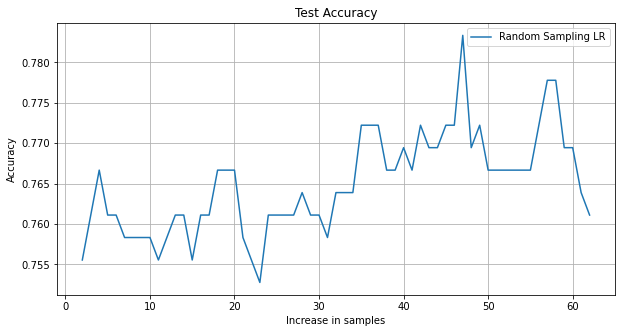

In [40]:
fig = plt.figure(figsize=(10,5))
plt.grid(True, which ="both")
plt.plot(select_count[0:-39], acc[0:-40])
plt.legend(['Random Sampling LR'])
plt.title('Test Accuracy')
plt.xlabel('Increase in samples')
plt.ylabel('Accuracy')

In [22]:
i

101

In [23]:
len(acc)

151